## Preparing data for fitting

Will place data into the model formula for both formulae given by Samraat.

# Import Packages

In [1]:
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from scipy.optimize import curve_fit
from scipy import stats as stats
from math import log as log
from math import pi as pi

# Import Data

In [2]:
data = pd.read_csv("../data/CRat.csv")
subset = data[data["ID"] == 39982]
ResDens = sc.array(subset["ResDensity"])
NTrait = sc.array(subset["N_TraitValue"])
type(ResDens)
type(NTrait)

numpy.ndarray

# Define Functions

## Function 1
Then, there is the more mechanistic Holling Type II model (Holling, 1959):

### **c=axR / 1+haxR**

Here, xR
is resource density (Mass / Area or Volume), a is consumer's search rate (Area or Volume / Time ), and h is handling time of the consumer for that resource (time taken to overpower and ingest it).


In data:

a = free variable?

Xr = ResDensity

h = free variable?

In [3]:
def calc_C(Xr, a, h):
    """The equation for the type II functional response from Holling, 1959"""
    top = a*Xr
    bot = 1 + (h*a*Xr)
    C = top/bot
    return C 

VVVThis generates the coeficient of the modelVVV

In [4]:
popt, pcov = curve_fit(f = calc_C, xdata = ResDens, ydata = NTrait , p0 = [.1, .1], method = 'lm')
popt

array([  1.86343017e-04,   3.55860752e+01])

Generate a series of Resource denities to use when generating model line.
Also sort it so the line is smooth and doesn't jump around.

In [5]:
RDensities = sc.random.uniform(min(NTrait), max(NTrait), 200)
RDensities.sort()
# RDensities

Text(0, 0.5, 'N_TraitValue')

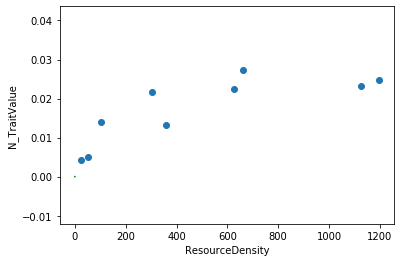

In [6]:
plt.scatter(ResDens, NTrait)
# plt.plot(ResDens, calc_C(ResDens, *popt), '-r')
plt.plot(RDensities, calc_C(RDensities, *popt), '-g')
plt.xlabel('ResourceDensity')
plt.ylabel('N_TraitValue')

## Function 2
There is also the less-mechanistic "generalized" functional response model:

c=axR^q+1 /

   1+haxR^q+1
   
q also need to be defined for this.

In [7]:
def calc_CQ(Xr, a, h, q=0.8):  ## arbitrarily difined right now as 0.8
    """The equation for the more general Type II functional response curve.  
    Includes a dimensionless parameter `q` which is used to account for a small lag phase at the start of the curve"""
    top = a*Xr**(q+1)
    bot = 1 + (h*a*Xr**(q+1))
    C = top/bot
    return C 

### Fit function 2 Using curve_fit

In [8]:
popt, pcov = curve_fit(f = calc_CQ, xdata = ResDens, ydata = NTrait, p0 = [.1, .1], method = 'lm')
popt

array([  6.23968576e-06,   4.25476355e+01])

In [9]:
RDensities = sc.random.uniform(min(NTrait), max(NTrait), 200)
RDensities.sort()

In [10]:
pcov

array([[  9.73540576e-12,   4.02303786e-06],
       [  4.02303786e-06,   1.07198271e+01]])

Text(0, 0.5, 'N_TraitValue')

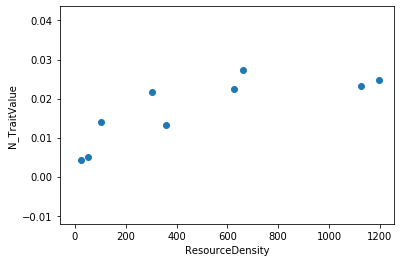

In [11]:
plt.scatter(ResDens, NTrait)
# plt.plot(ResDens, calc_CQ(ResDens, *popt), '-r')
plt.plot(RDensities, calc_CQ(RDensities, *popt), '-g')
plt.xlabel('ResourceDensity')
plt.ylabel('N_TraitValue')

### Fit function 2 using lmfit

In [12]:
def calc_CQlmfit(params, Xr):  ## arbitrarily difined right now as 0.05
    """The equation for the more general Type II functional response curve.
    Need an argument params which is a dictionary containing the parameter values.
    This dictionary is made using lmfit.parameters().
    Includes a dimensionless parameter `q` which is used to account for a small lag phase at the start of the curve"""
    vals = params.valuesdict()
    a = vals['a']
    h = vals['h']
    q = vals['q']
    
    top = a*Xr**(q+1)
    bot = 1 + (h*a*Xr**(q+1))
    C = top/bot
    return C 

In [13]:
# CQMod = lmfit.Model(calc_CQ)
# print(CQMod.param_names)


val_a =.1
val_h = .1
val_q = .8

CQParams = lmfit.Parameters()
CQParams.add_many(('a', val_a), ('h', val_h), ('q', val_q))
CQParams.valuesdict()['a']



CQ = lmfit.minimize(fcn = calc_CQlmfit, params = CQParams, args = (ResDens,)) # the `,` seems to make it go through item wise


# CQ = lmfit.Model(calc_CQ)
# CQ.set_param_hint('a', value=.1)
# CQ.set_param_hint('h', value=.1)
# CQ_params = CQ.make_params()
# out = CQ.fit(x = ResDens, params)
CQ

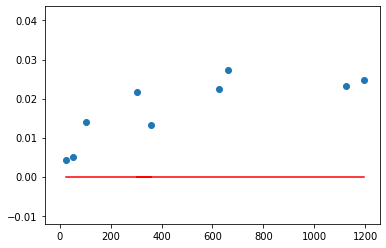

In [61]:
FittedVals = CQ.params.valuesdict()
calc_CQlmfit(CQ.params, ResDens)
# print(calc_CQlmfit(CQ.params, RDensities))
# print(calc_CQlmfit(CQ.params, ResDens))
plt.scatter(ResDens, NTrait)
plt.plot(ResDens, calc_CQlmfit(CQ.params, ResDens), '-r')
plt.plot(RDensities, calc_CQlmfit(CQ.params, RDensities), '-g')
# plt.xlabel('ResourceDensity')
# plt.ylabel('N_TraitValue')

# Calculate RSS
ModelFit = the fitted NLS Model

data2fitx = data we are using for the x axis of our model, i.e. ResDens


**Mode not needed in funtion below?**

In [15]:
def calc_RSS(data2fitx, ModelFit, Model = calc_C, mode = "NLS"):## model var is to specifty which equation should be used. Model fit is popt under sc.optimize
    """Calculates the Residual Sum of Squares for a set of data given the model fit.  
    The equation used to fit the model can also be changed using the `Model` argument, default is the `calc_C` function.
    Can be used for both NLS and lm, specified with mode = "NLS" OR "lm"."""
    diffList = []
    a = ModelFit[0] # search rate
    h = ModelFit[1] # handling time

    if mode == "NLS":
        for i in range(len(data2fitx)):
        #find diff between model and observed
            diffList.append(abs(Model(data2fitx[i], a, h) - data2fitx[i])**2)
            #sum the values
            RSS = sum(diffList)

    if mode == "lm":
        for i in range(len(data2fitx)):
        #find diff between model and observed
            diffList.append(abs(Model(data2fitx[i], a, h) - data2fitx[i])**2)
        #sum the values
            RSS = sum(diffList)
    
    return RSS  

RSS = calc_RSS(ResDens, popt, Model=calc_CQ)
RSS

3761630.9930024752

# Calculating AIC

***from Model Fitting Notes***

ModelFit = the fitted NLS Model

n <- nrow(Data2Fit) #set sample size

pModel <- length(coef(ModelFit)) # get number of parameters in power law model

Model_RSS <- sum(residuals(ModelFit)^2) 

AIC_Model <- n + 2 + n * log((2 * pi) / n) +  n * log(Model_RSS) + 2 * pModel


This is to find the number of parameters of the model

In [16]:
def pModel(coefficients):
    """Return number of parameters of a model when given a list of them."""
    return len(coefficients)
p = pModel(popt)
p

2

In [17]:
def AIC(data2fit, n, Model_RSS, pModel):
    """Calculates the AIC value given the data (data2fit), number of samples (n), 
    the RSS of the model (Model_RSS) and number of parameters in the model(pModel)."""
    return n + 2 + n * log((2 * pi) / n) + n * log(Model_RSS) + 2 * pModel

AIC(ResDens, len(ResDens), RSS, p)

148.02914116608756

# Calculating BIC

***From Model FItting Lecture notes***

n + 2 + n *ln(2pi/n) + n *ln(RSS) + p *ln(n)

log in python and R is natural log by default.  log 10 is base 10.

In [18]:
def calc_BIC(data2fit, n, Model_RSS, pModel):
    """Calculates the BIC value given the data (data2fit), number of samples (n), 
    the RSS of the model (Model_RSS) and number of parameters in the model(pModel)."""
    return n + 2 + n *log(2*pi/n) + n *log(RSS) + p *log(n)

calc_BIC(ResDens, len(ResDens), RSS, p)

148.42359032075998

# Estimate Starting Values

`h` estimate => the max value for the `N_TrainValue`

`a` estimate => the slope of a `lm` for  the model,  can remove upper `ResDens`values until highest `AIC` is obtained.

**Caveats** 
* `a` will not account for lag phase
* `a` will not look at `IC` can see if this changes values significantly and read into which should be better for this dataset.



**Alternative Methods to Try**

* log transform the data for obtaining `a`
* find the top several values of `N_Trait val` and obtain a mean OR lm and take the intercept.
    * could be negative slope in which case this is questionable

### Estimate `h`

In [62]:
h = max(ResDens)
h

1197.0154

### Estimate `a`

In [70]:
best_a = None # for recording the value of `a` which gave the lowest RSS value.
smallest_RSS = None # for recording the lowest RSS value.

# equalList = []#list for storing any equal results
for i in range(len(ResDens), -1, -1): ## loop back from len(ResDens)

    tmpRegress = stats.linregress(ResDens[0:i], NTrait[0:i])
    paramEst =  [tmpRegress[0], h]#parameters for this iteration, h is found beforehand. a is slope of the line
    print(paramEst)
    if smallest_RSS == None: # i.e. first loop
        
        smallest_RSS = calc_RSS(ResDens[0:i],paramEst, Model = calc_CQ)
        smallest_a = tmpRegress[0]
        
    elif calc_RSS(ResDens[0:i],params, Model = calc_CQ) < smallest_RSS:#if RSS is smaller record
        
        if sc.isnan(tmpRegress[0]): # skip if a becomes nan
            break
            
        else:
            smallest_RSS = calc_RSS(ResDens[0:i], paramEst, Model = calc_CQ)
            smallest_a = tmpRegress[0]


#     elif: #if equal what to do?
    
    else: #if not skip
        print("bigger")
        
        
    if paramEst[0] == sc.nan:
        print("boo")
    print(type(smallest_a))
    print(type(paramEst[0]))
        
        
        
#         print(type(params))
#         smallest_RSS = RSS(ResDens, params, Model = calc_C)
        
    


stats.linregress(ResDens, NTrait)[0]











[   25.6513    51.1261   103.6368   357.0664   304.7364   624.6364
   659.722   1126.5904  1197.0154]
[1.5383667372729225e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[   25.6513    51.1261   103.6368   357.0664   304.7364   624.6364
   659.722   1126.5904]
[1.7997701541799419e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[  25.6513   51.1261  103.6368  357.0664  304.7364  624.6364  659.722 ]
[3.0113689425571859e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[  25.6513   51.1261  103.6368  357.0664  304.7364  624.6364]
[2.8324425049477198e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[  25.6513   51.1261  103.6368  357.0664  304.7364]
[3.6682123019541039e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[  25.6513   51.1261  103.6368  357.0664]
[2.4043844473830938e-05, 1197.0154]
<class 'numpy.float64'>
<class 'numpy.float64'>
[  25.6513   51.1261  103.6368]
[0.00013134836542616818, 1197.0154]
<class 

/usr/lib/python3/dist-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/lib/python3/dist-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/lib/python3/dist-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


1.5383667372729225e-05

In [68]:
sc.nan

nan

### **Concerns**
is it reasonable to stop once the RSS is no longer improving, i.e. assume we have removed all asymptoted data points

### example on using optimize.curve_fit from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit


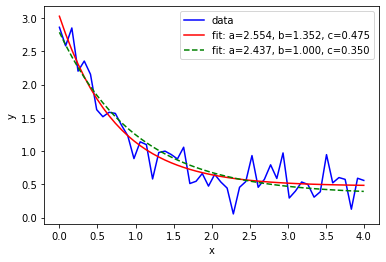

In [21]:
# 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define the data to be fit with some noise:


xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

# Fit for the parameters a, b, c of the function func:


popt, pcov = curve_fit(func, xdata, ydata)
popt

plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

# Constrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5:


popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt

plt.plot(xdata, func(xdata, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))



plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



for starting values can look at the plots 

can also try to run the freeplot 1000x and use values generated by that

## Notes on finding starting values

by looking at tangents at different parts of model you can get reasonable starting values for parameters.

break up curve and fit lm to each section. (the lm shouldnt deviate each run so no need to repeat)

a is the increaseing section
h is the leveled out max section
    
once this is optimised.  If there are a lot of failed fits then can sample around the estimated starting values from a distribution to further optimise

find line for h, i.e. take last point and vals near it/ last two vals and make a line.  take a to be all vals below that line's intercept.

for a can fit a polynomial and slowly remove points, once the polynomial stops fitting then it should be linear.

![Board from class](NotebookPictures/startingVals.jpg)